In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
from tqdm import tqdm

# Fatigue and Learning

In this notebook we will analyze the effect of fatigue/learning based on the force plate measurements (gold standard)

In [60]:
# Load data
older_adults_trial_level = pd.read_csv("../data/processed/older_adults/filtered_measurements.csv")

## Average Trends

In [22]:
def plot_learning_fatigue_trend_side_by_side(df):
    force_df = df[df['device'] == 'Force_Plate']
    metrics = force_df['metric'].unique()

    # Group metrics into pairs
    metric_pairs = [metrics[i:i+2] for i in range(0, len(metrics), 2)]

    for pair in metric_pairs:
        fig, axes = plt.subplots(1, len(pair), figsize=(16, 4), sharey=False)

        if len(pair) == 1:
            axes = [axes]  # Make it iterable even if only one plot

        for ax, metric in zip(axes, pair):
            metric_df = force_df[force_df['metric'] == metric]

            sns.lineplot(
                data=metric_df,
                x='trial', y='value',
                hue='state',
                errorbar=('ci', 68),
                estimator='mean',
                ax=ax
            )

            ax.set_title(f'Average Trend – {metric}')
            ax.set_ylabel('Value')
            ax.set_xlabel('Trial')
            ax.set_xticks([1, 2, 3, 4, 5])
            ax.set_ylim(bottom=0)
            ax.grid(True)
            ax.legend(title='State')

        plt.tight_layout()
        plt.show()

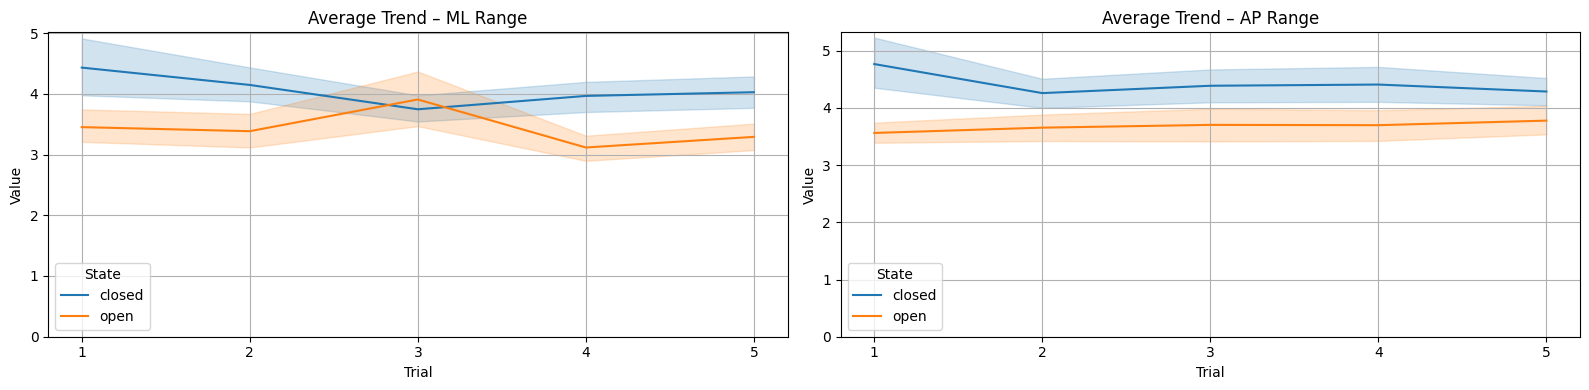

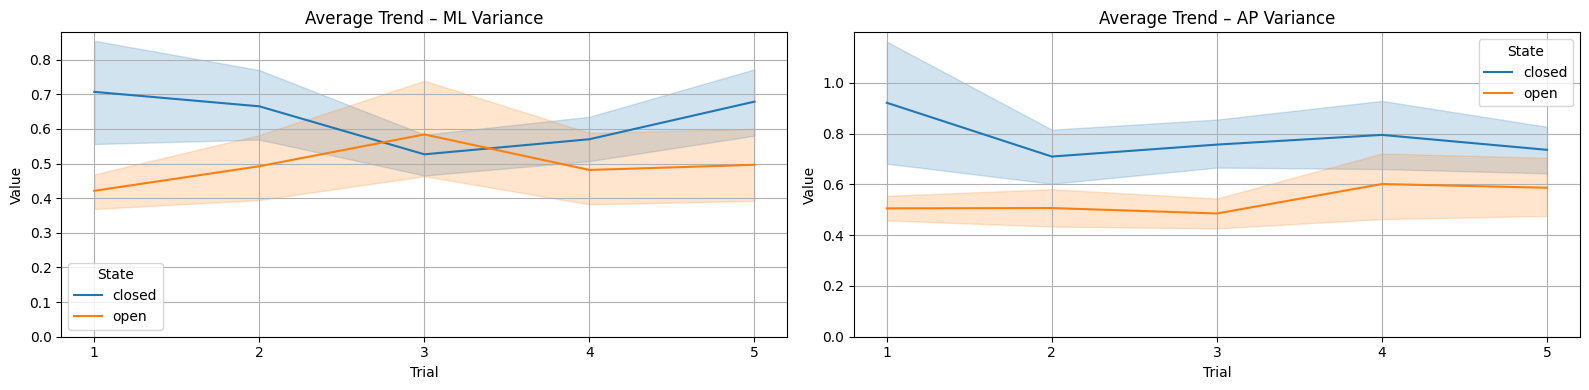

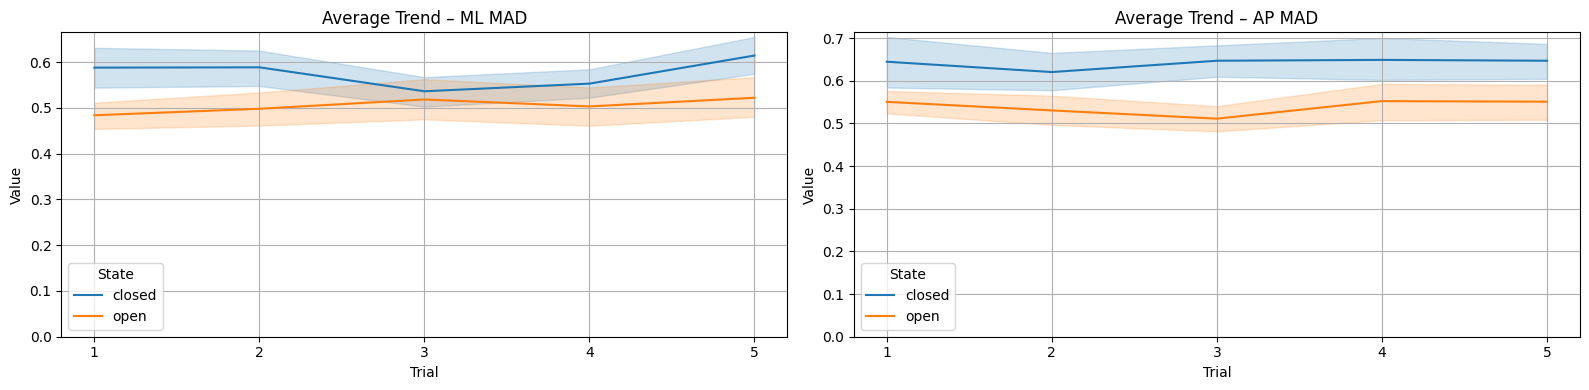

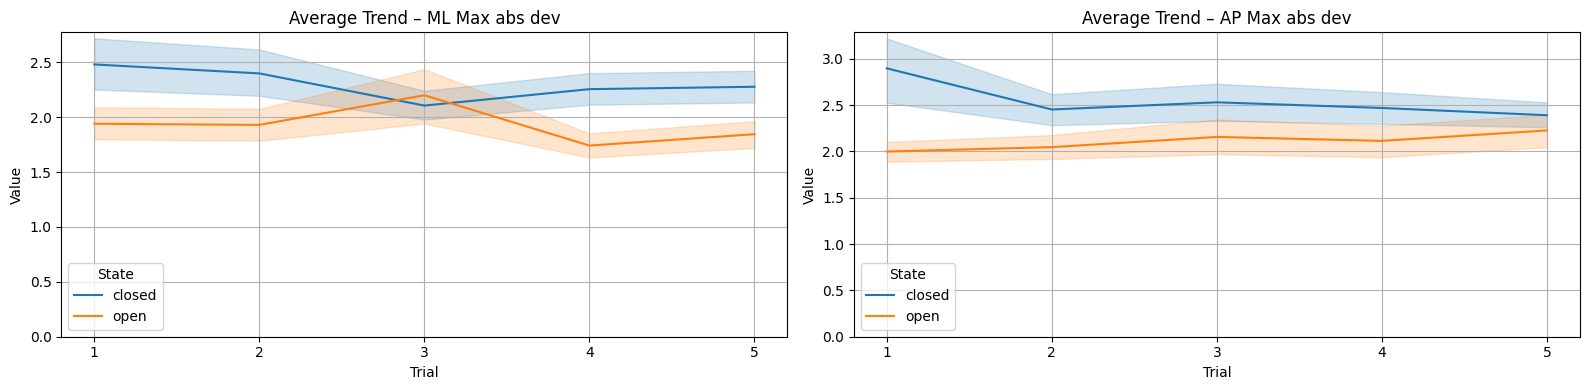

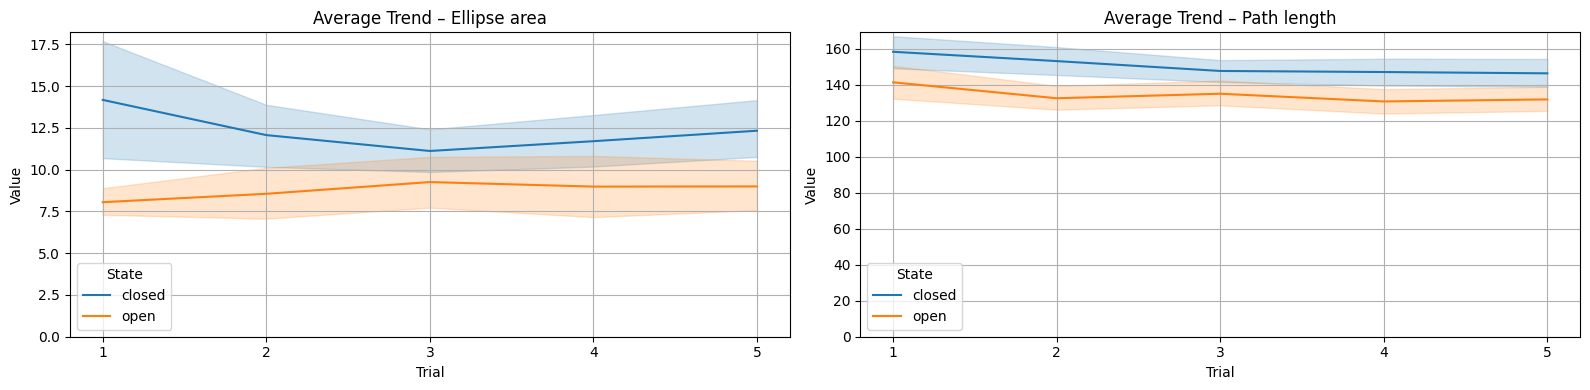

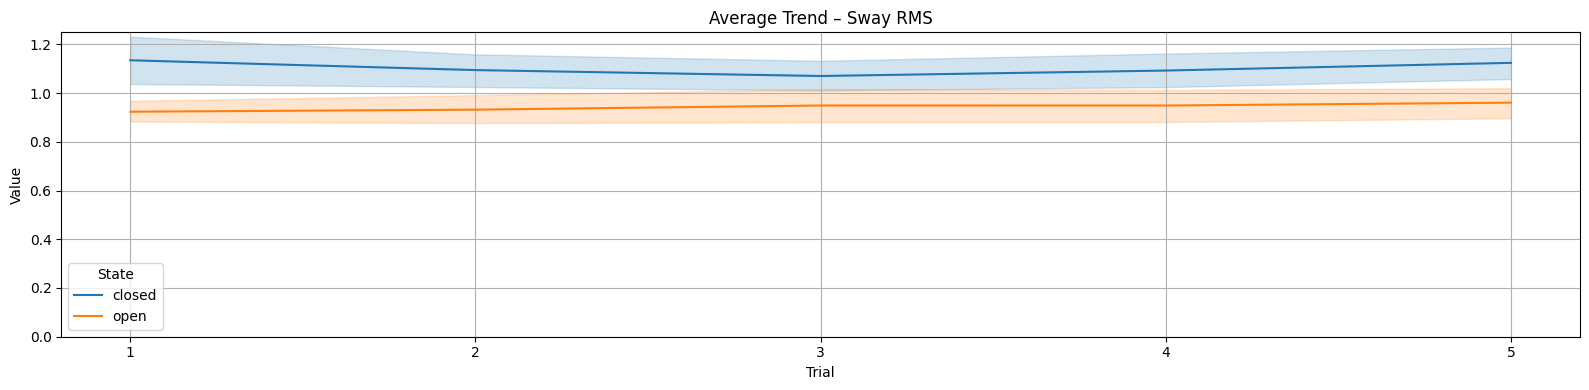

In [23]:
plot_learning_fatigue_trend_side_by_side(older_adults_trial_level)

## Model Fitting

In this section, we fit linear mixed-effects models for each metric and state. We model both a linear trend (trial-centered) and a quadratic trend (trial-centered squared), with random intercepts for each participant.

We model the trial-related trend separately for each state (eyes open and eyes closed) using a linear mixed-effects framework that allows for non-linear trajectories:

$$
value_{ij} = \beta_0 + \beta_1 \times trial_{ij} + \beta_2 \times trial_{ij}^2 + u_j + \epsilon_{ij}
$$

Where:
- $value_{ij}$ = observed measurement for participant $j$ at trial $i$
- $\beta_0$ = overall intercept (average value when centered trial = 0)
- $\beta_1$ = linear trend across trials (positive = fatigue, negative = learning)
- $\beta_2$ = quadratic trend across trials (captures non-linear learning or fatigue patterns)
- $u_j$ = random intercept for each participant $j$
- $\epsilon_{ij}$ = residual error

**Notes:**
- Trials are centered (trial 3 → 0).
- Inclusion of a quadratic term allows the model to capture non-linear effects such as initial improvement followed by deterioration.


In [29]:
# Step 1: Filter to Force Plate only
force_df = older_adults_trial_level[older_adults_trial_level['device'] == 'Force_Plate'].copy()

# Step 2: Split by State (Eyes Open and Eyes Closed)
eyes_open_df = force_df[force_df['state'] == 'open'].copy()
eyes_closed_df = force_df[force_df['state'] == 'closed'].copy()

# Step 3: Center Trial Number
# Trials are 1-5 → center around 3
eyes_open_df['trial_centered'] = eyes_open_df['trial'] - 3
eyes_closed_df['trial_centered'] = eyes_closed_df['trial'] - 3

# Step 4: Create Squared Term (trial^2)
eyes_open_df['trial_centered_sq'] = eyes_open_df['trial_centered']**2
eyes_closed_df['trial_centered_sq'] = eyes_closed_df['trial_centered']**2

In [43]:
# Collect results
results = []
fitted_models = {}  # <--- Dictionary to store fitted models

metrics = eyes_open_df['metric'].unique()
states = ['open', 'closed']

state_df_map = {
    'open': eyes_open_df,
    'closed': eyes_closed_df
}

for state in states:
    df_state = state_df_map[state]

    for metric in metrics:
        df_metric = df_state[df_state['metric'] == metric]

        if df_metric.empty:
            continue  # Skip if no data for this combination

        try:
            model = smf.mixedlm(
                "value ~ trial_centered + trial_centered_sq",
                df_metric,
                groups=df_metric["participant name"]
            ).fit()

            # Save model in dictionary
            model_key = f"{state}_{metric}"
            fitted_models[model_key] = model

            # Extract needed information
            intercept_coef = model.params.get('Intercept', np.nan)
            intercept_pval = model.pvalues.get('Intercept', np.nan)

            trial_coef = model.params.get('trial_centered', np.nan)
            trial_pval = model.pvalues.get('trial_centered', np.nan)

            trial2_coef = model.params.get('trial_centered_sq', np.nan)
            trial2_pval = model.pvalues.get('trial_centered_sq', np.nan)

            results.append({
                'State': state,
                'Metric': metric,
                'β0 (Intercept)': intercept_coef,
                'p-value β0': intercept_pval,
                'β1 (trial_centered)': trial_coef,
                'p-value β1': trial_pval,
                'β2 (trial_centered_sq)': trial2_coef,
                'p-value β2': trial2_pval
            })

        except Exception as e:
            print(f"Model failed for {state} - {metric}: {e}")

# Create the summary DataFrame
summary_df = pd.DataFrame(results)
summary_df = summary_df.sort_values(['State', 'Metric']).reset_index(drop=True)

summary_df

,State,Metric,β0 (Intercept),p-value β0,β1 (trial_centered),p-value β1,β2 (trial_centered_sq),p-value β2
0,closed,AP MAD,0.638918,2.338602e-53,0.002855,0.755451,0.001096,0.887291
1,closed,AP Max abs dev,2.462473,4.596322e-39,-0.099872,0.069820,0.042109,0.364845
2,closed,AP Range,4.326542,5.671285e-52,-0.082559,0.227007,0.046387,0.421003
3,closed,AP Variance,0.742148,4.143459e-09,-0.029656,0.391918,0.020473,0.483535
4,closed,Ellipse area,11.280570,1.234945e-09,-0.418942,0.355914,0.490590,0.200001
5,closed,ML MAD,0.548926,1.357188e-56,0.001534,0.832182,0.013477,0.027351
6,closed,ML Max abs dev,2.210502,1.799601e-44,-0.054564,0.183118,0.046725,0.176582
7,closed,ML Range,3.875208,1.766723e-45,-0.099330,0.132786,0.093725,0.092677
8,closed,ML Variance,0.560765,2.746035e-10,-0.015759,0.477261,0.034045,0.068731
9,closed,Path length,148.515457,4.099978e-93,-2.823542,0.003399,1.114002,0.170665


In [41]:
def interpret_row(row, alpha=0.05):
    # Extract needed values
    beta1 = row['β1 (trial_centered)']
    p_beta1 = row['p-value β1']
    beta2 = row['β2 (trial_centered_sq)']
    p_beta2 = row['p-value β2']

    # Default interpretation
    interpretation = "No effect"

    # Check significance
    if p_beta2 < alpha:
        if beta2 < 0:
            interpretation = "Learning then fatigue"
        else:
            interpretation = "Fatigue then learning"
    elif p_beta1 < alpha:
        if beta1 < 0:
            interpretation = "Learning"
        else:
            interpretation = "Fatigue"

    return interpretation

In [42]:
# Now build the interpretation table
metrics = summary_df['Metric'].unique()

interpretation_rows = []

for metric in metrics:
    # Get rows for this metric
    open_row = summary_df[(summary_df['Metric'] == metric) & (summary_df['State'] == 'open')]
    closed_row = summary_df[(summary_df['Metric'] == metric) & (summary_df['State'] == 'closed')]

    open_interp = interpret_row(open_row.iloc[0]) if not open_row.empty else "no data"
    closed_interp = interpret_row(closed_row.iloc[0]) if not closed_row.empty else "no data"

    interpretation_rows.append({
        'Metric': metric,
        'Eyes Open': open_interp,
        'Eyes Closed': closed_interp
    })

# Create the final interpretation DataFrame
interpretation_df = pd.DataFrame(interpretation_rows)
interpretation_df

,Metric,Eyes Open,Eyes Closed
0,AP MAD,No effect,No effect
1,AP Max abs dev,No effect,No effect
2,AP Range,No effect,No effect
3,AP Variance,No effect,No effect
4,Ellipse area,No effect,No effect
5,ML MAD,No effect,Fatigue then learning
6,ML Max abs dev,No effect,No effect
7,ML Range,No effect,No effect
8,ML Variance,No effect,No effect
9,Path length,Learning,Learning


In [47]:
def check_model_assumptions_side_by_side(model_open, model_closed, metric_name):
    """
    Create 4 plots in one row:
    - Eyes Open: QQ Plot + Residuals vs Fitted
    - Eyes Closed: QQ Plot + Residuals vs Fitted
    """
    # Get residuals and fitted values
    residuals_open = model_open.resid
    fitted_open = model_open.fittedvalues

    residuals_closed = model_closed.resid
    fitted_closed = model_closed.fittedvalues

    # Create figure with 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Eyes Open - QQ Plot
    stats.probplot(residuals_open, dist="norm", plot=axes[0])
    axes[0].set_title(f'Eyes Open - QQ Plot')

    # Eyes Open - Residuals vs Fitted
    sns.scatterplot(x=fitted_open, y=residuals_open, ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_xlabel('Fitted Values')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Eyes Open - Residuals vs Fitted')
    axes[1].grid(True)

    # Eyes Closed - QQ Plot
    stats.probplot(residuals_closed, dist="norm", plot=axes[2])
    axes[2].set_title(f'Eyes Closed - QQ Plot')

    # Eyes Closed - Residuals vs Fitted
    sns.scatterplot(x=fitted_closed, y=residuals_closed, ax=axes[3])
    axes[3].axhline(0, color='red', linestyle='--')
    axes[3].set_xlabel('Fitted Values')
    axes[3].set_ylabel('Residuals')
    axes[3].set_title('Eyes Closed - Residuals vs Fitted')
    axes[3].grid(True)

    plt.suptitle(f'Model Assumptions Check - {metric_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Also print Shapiro-Wilk p-values
    p_open = stats.shapiro(residuals_open).pvalue
    p_closed = stats.shapiro(residuals_closed).pvalue

    print(f"Shapiro-Wilk p-value (Eyes Open) for {metric_name}: {p_open:.4f}")
    print(f"Shapiro-Wilk p-value (Eyes Closed) for {metric_name}: {p_closed:.4f}")
    print("-" * 60)


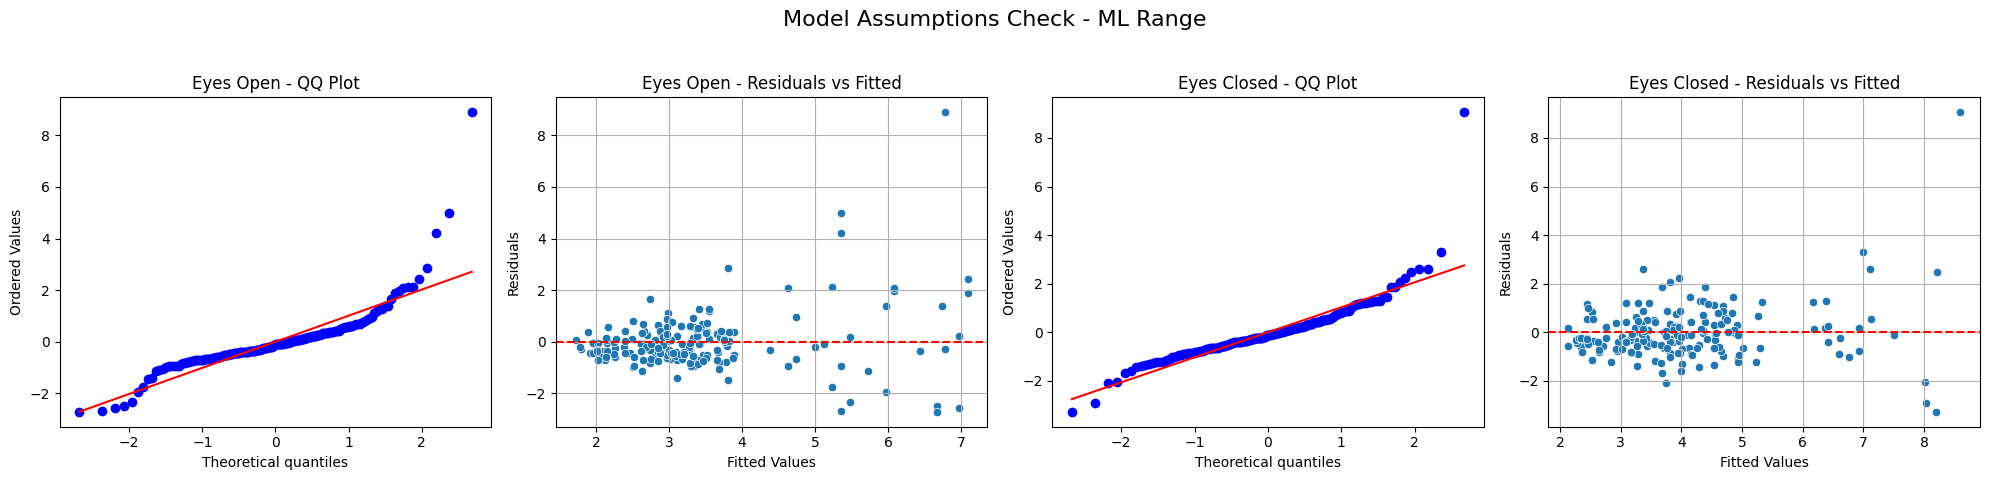

Shapiro-Wilk p-value (Eyes Open) for ML Range: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for ML Range: 0.0000
------------------------------------------------------------


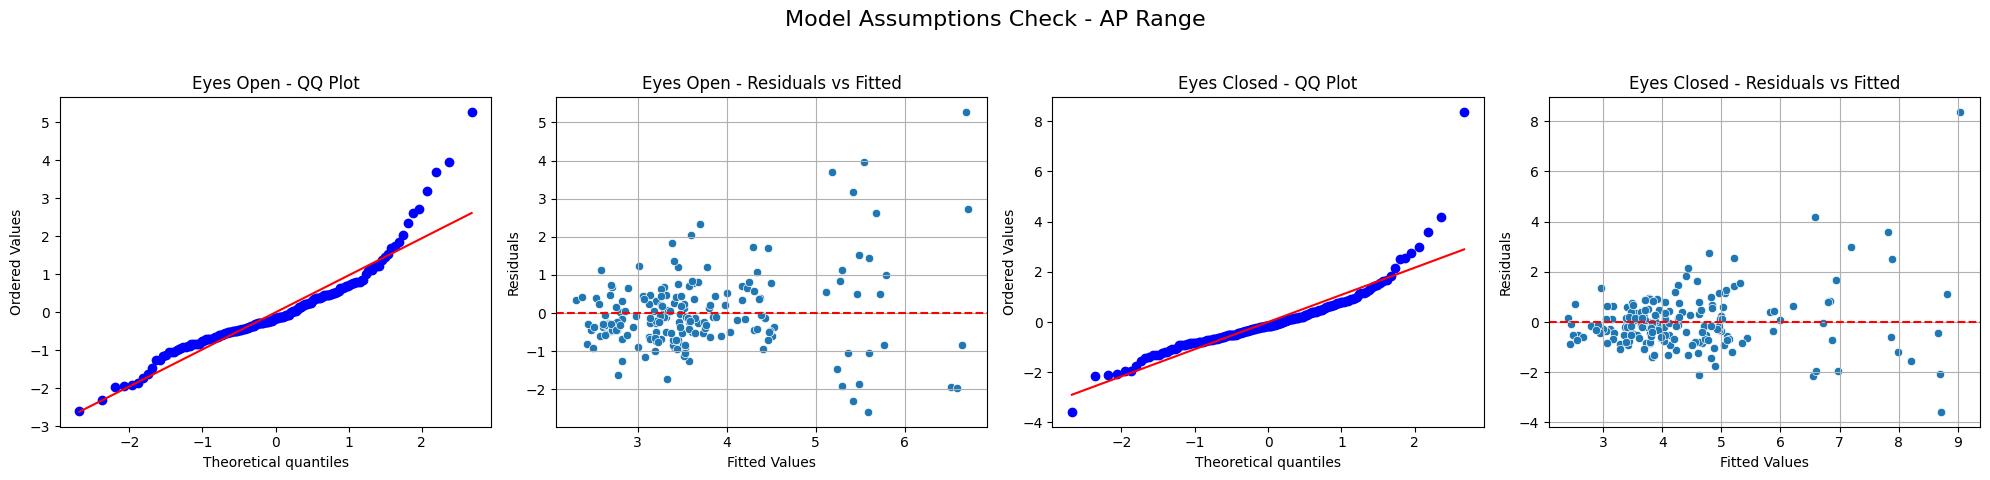

Shapiro-Wilk p-value (Eyes Open) for AP Range: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for AP Range: 0.0000
------------------------------------------------------------


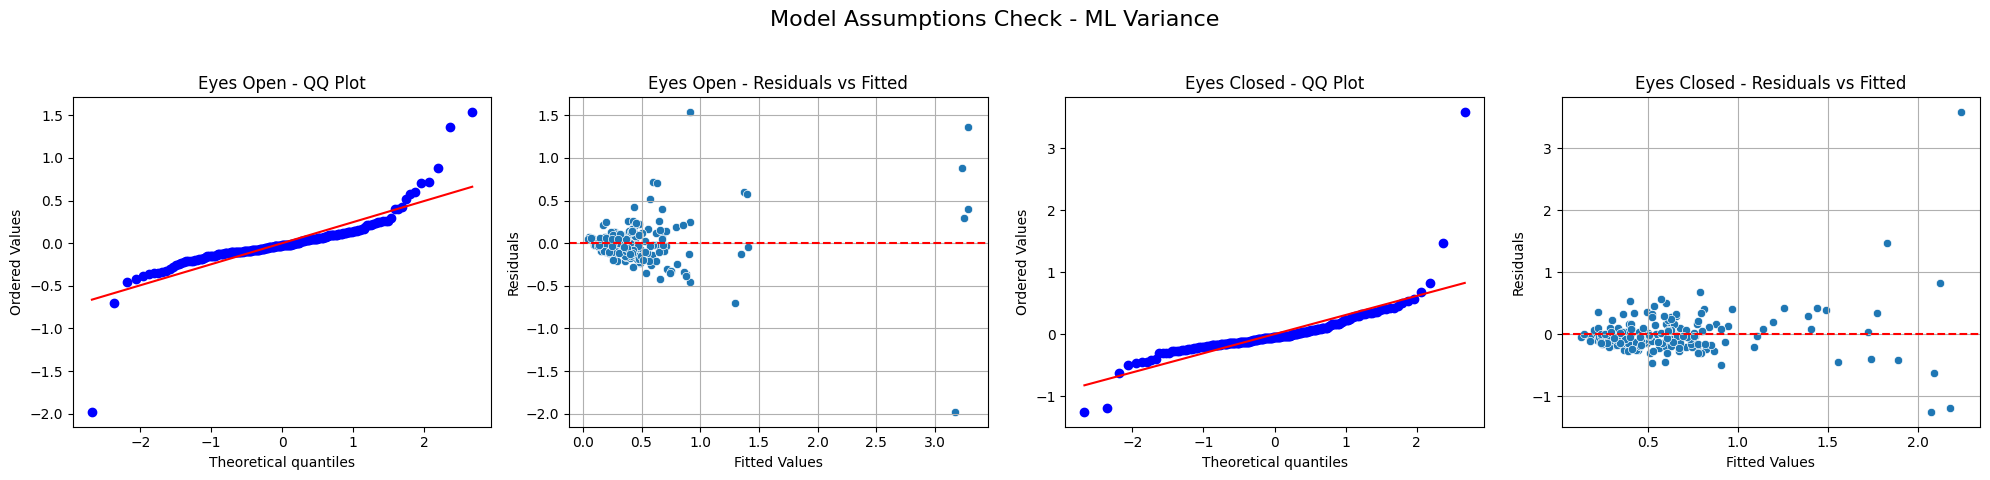

Shapiro-Wilk p-value (Eyes Open) for ML Variance: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for ML Variance: 0.0000
------------------------------------------------------------


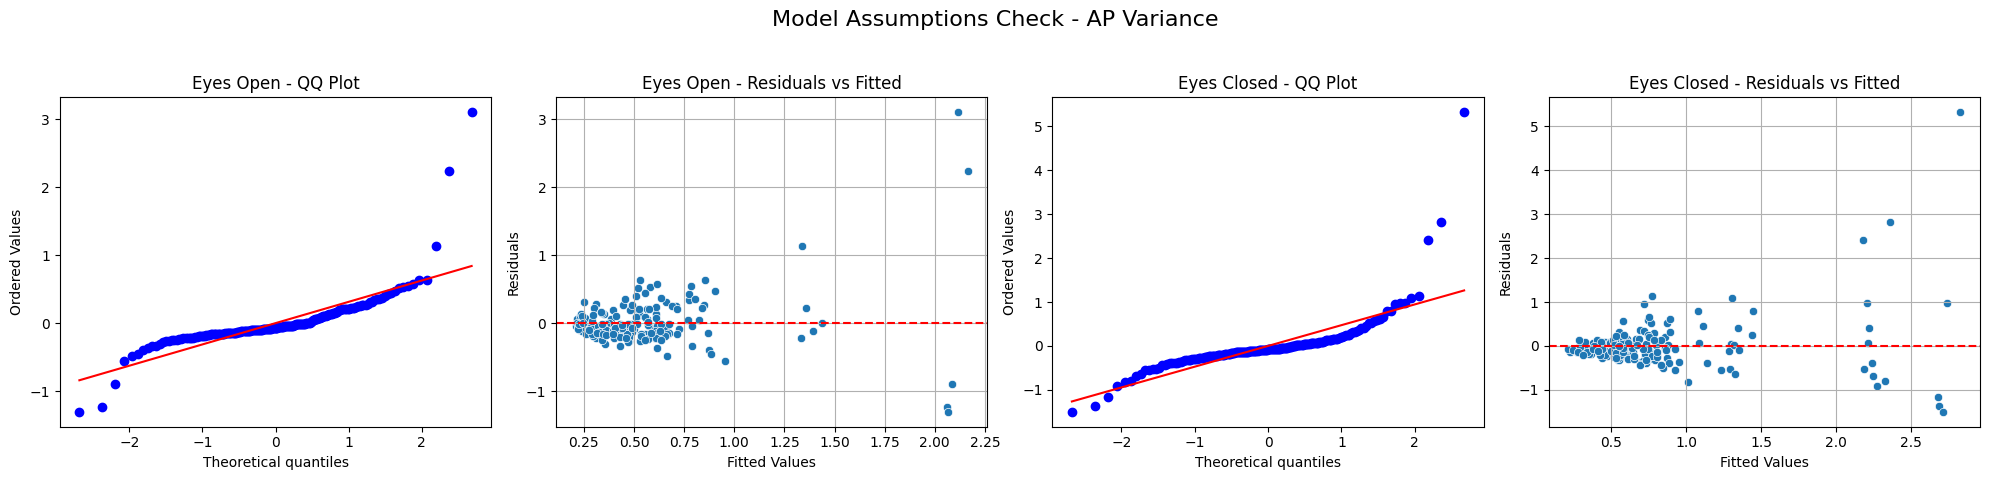

Shapiro-Wilk p-value (Eyes Open) for AP Variance: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for AP Variance: 0.0000
------------------------------------------------------------


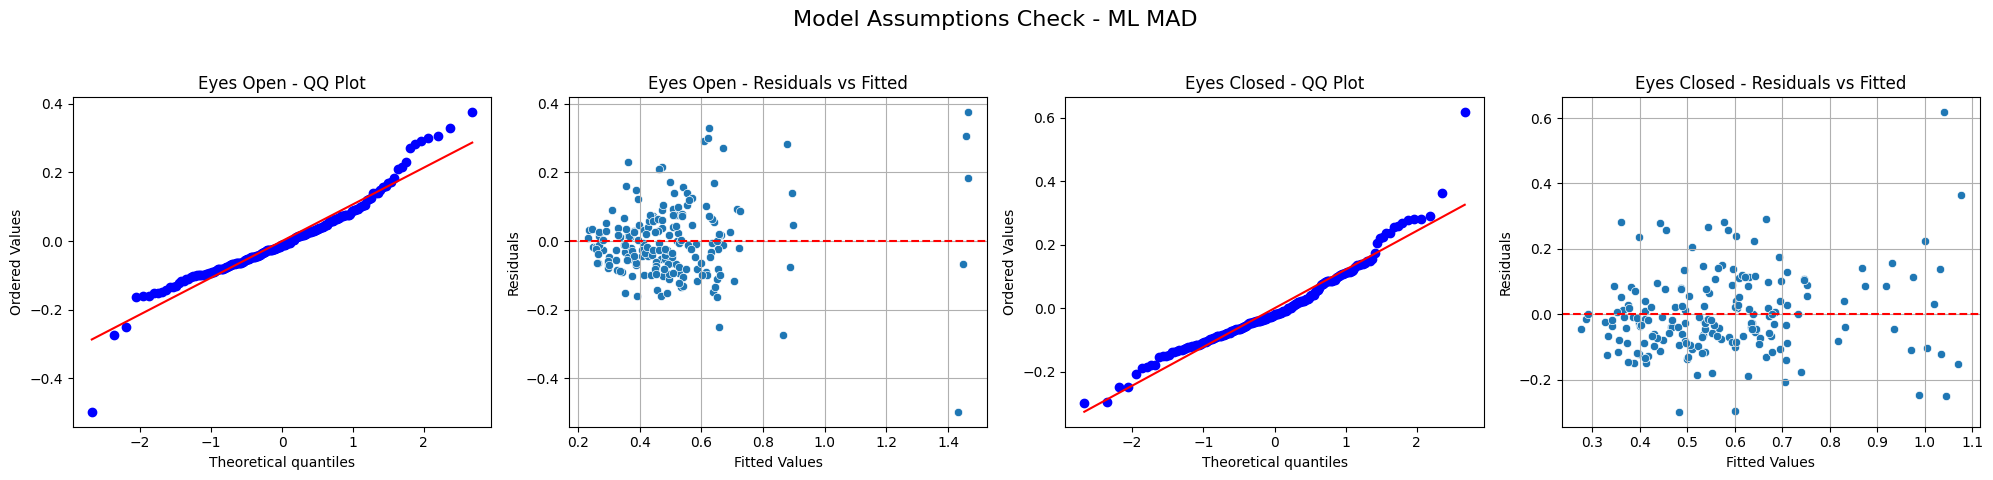

Shapiro-Wilk p-value (Eyes Open) for ML MAD: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for ML MAD: 0.0000
------------------------------------------------------------


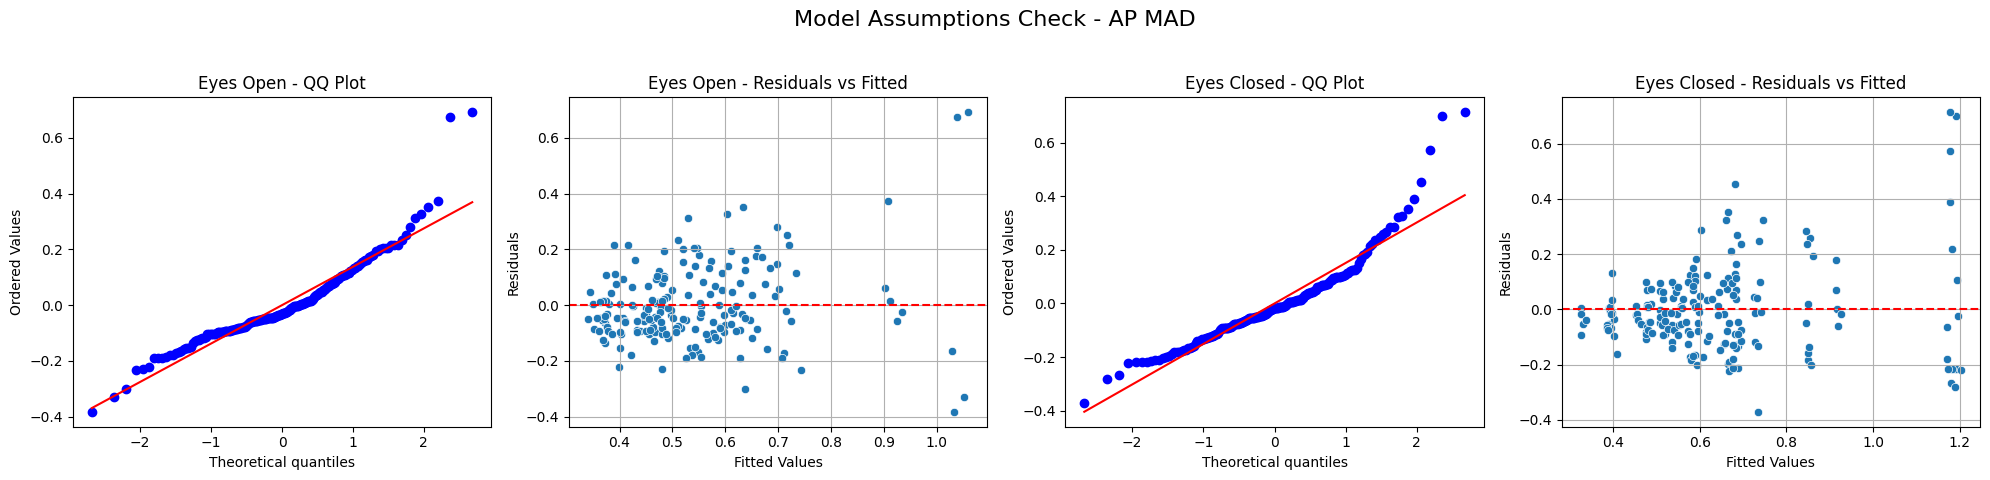

Shapiro-Wilk p-value (Eyes Open) for AP MAD: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for AP MAD: 0.0000
------------------------------------------------------------


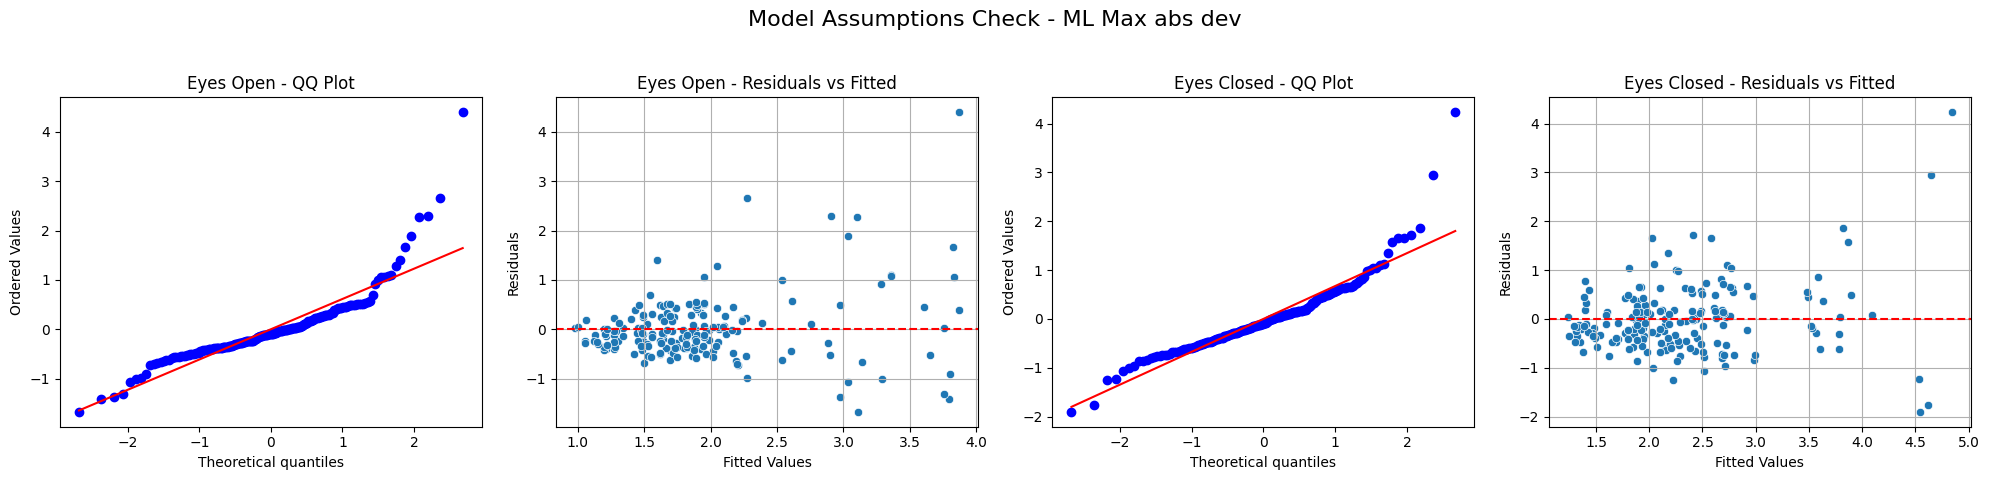

Shapiro-Wilk p-value (Eyes Open) for ML Max abs dev: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for ML Max abs dev: 0.0000
------------------------------------------------------------


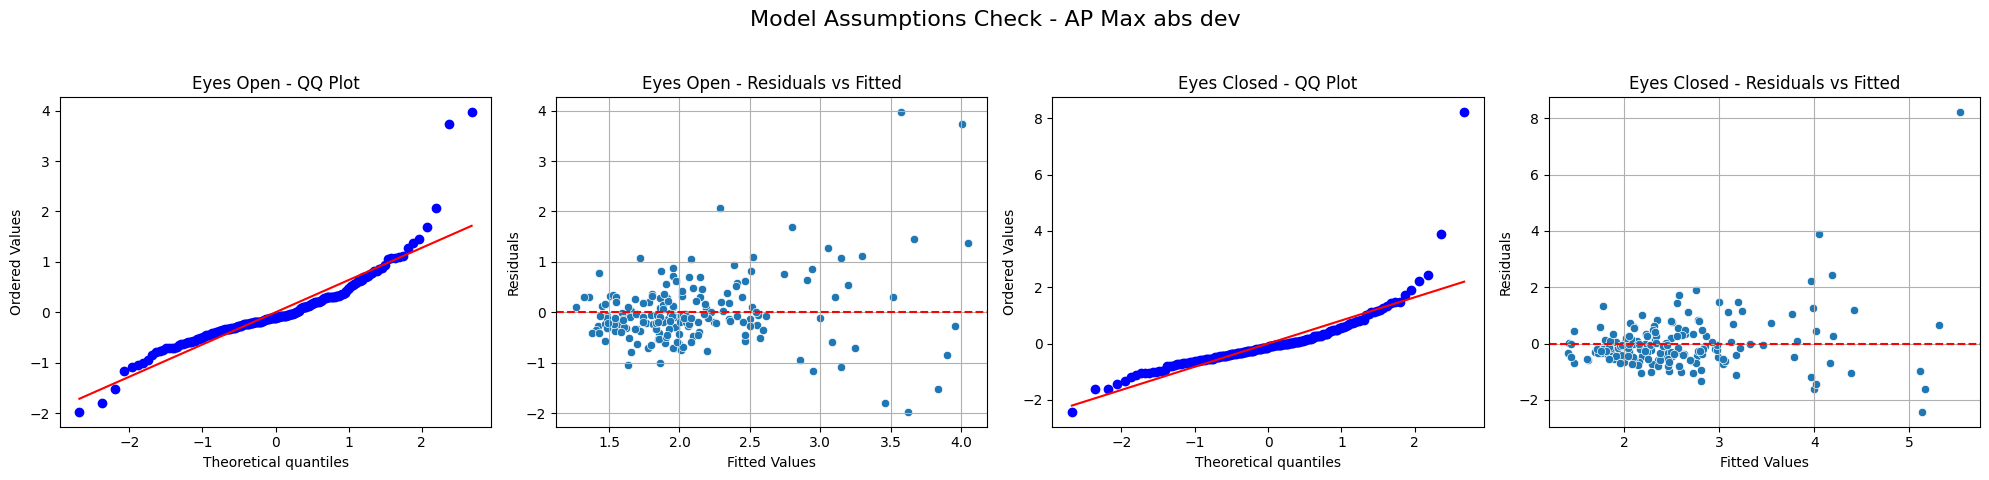

Shapiro-Wilk p-value (Eyes Open) for AP Max abs dev: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for AP Max abs dev: 0.0000
------------------------------------------------------------


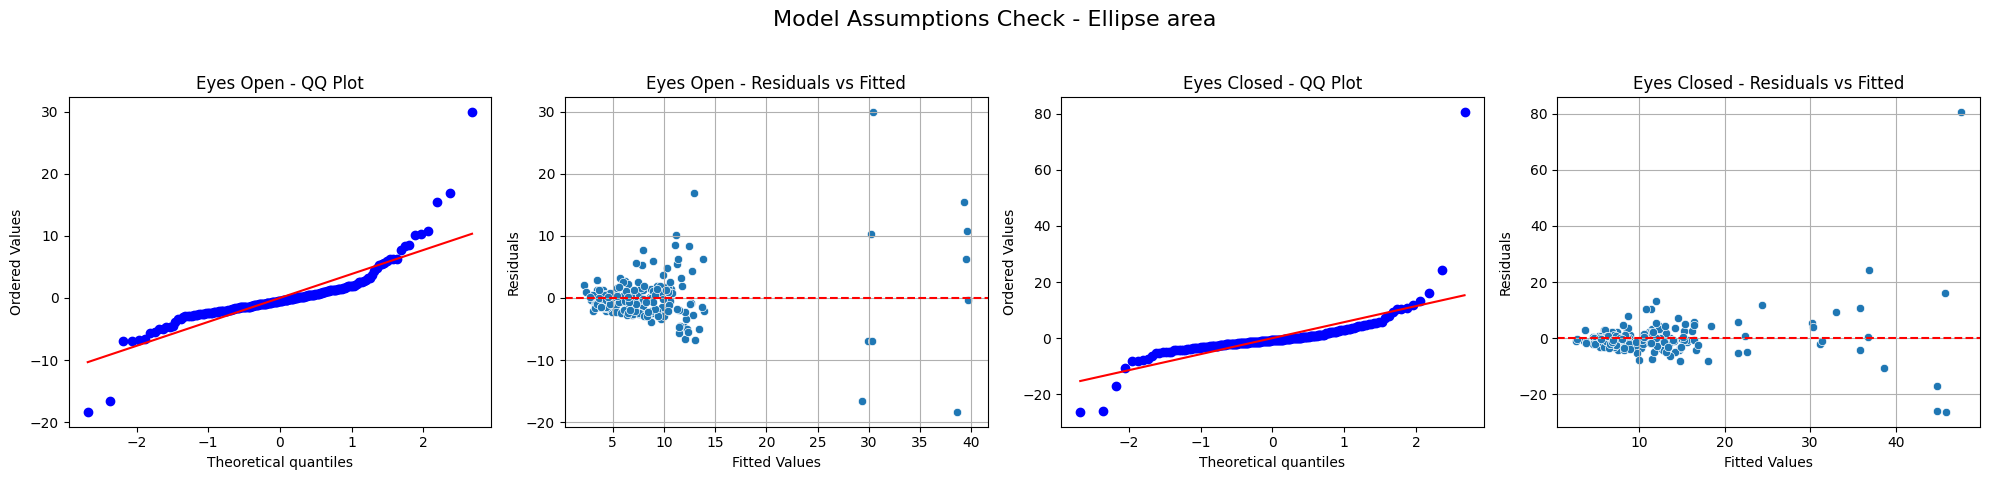

Shapiro-Wilk p-value (Eyes Open) for Ellipse area: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for Ellipse area: 0.0000
------------------------------------------------------------


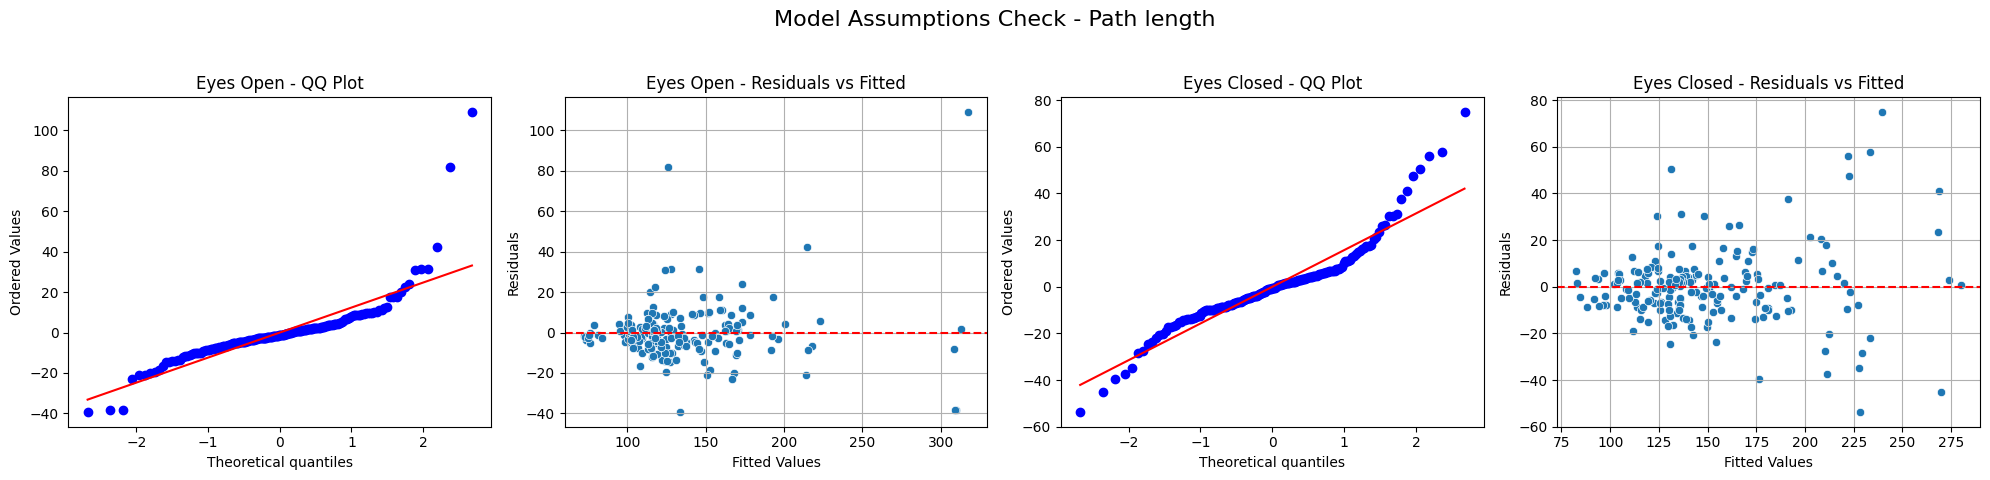

Shapiro-Wilk p-value (Eyes Open) for Path length: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for Path length: 0.0000
------------------------------------------------------------


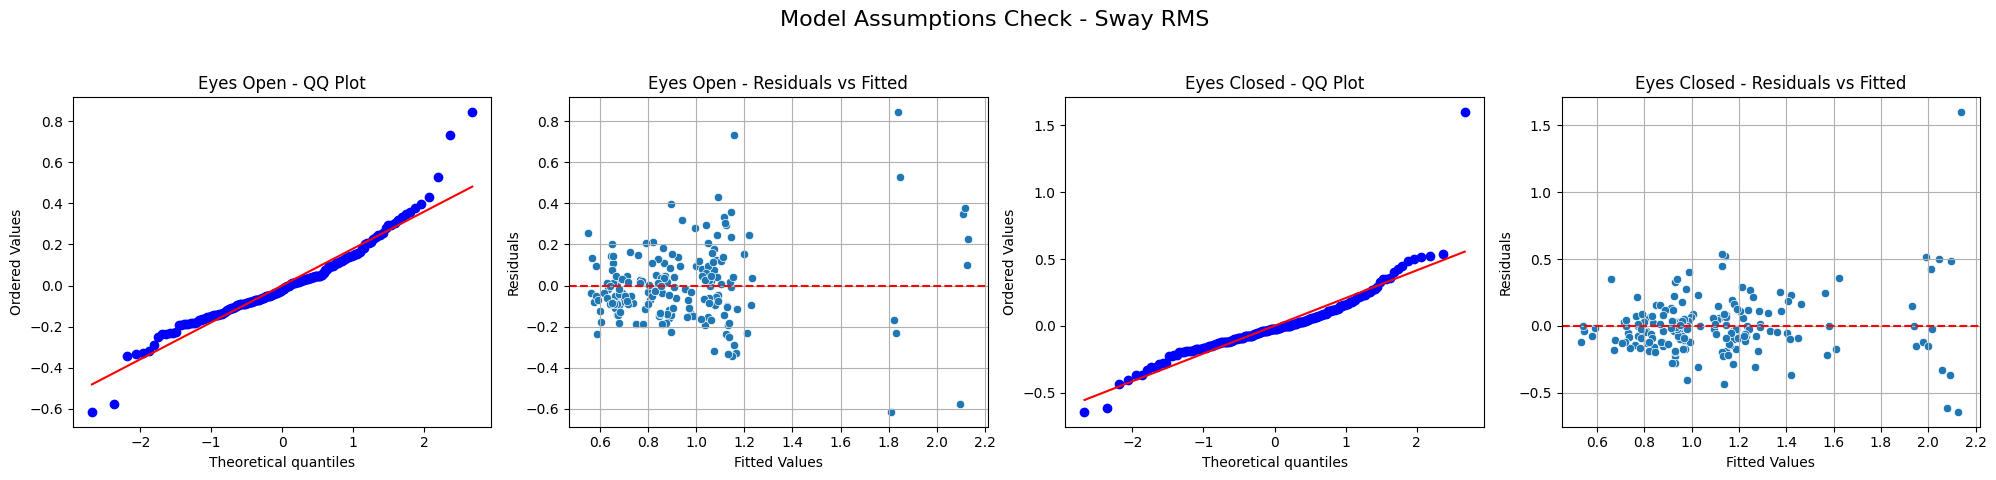

Shapiro-Wilk p-value (Eyes Open) for Sway RMS: 0.0000
Shapiro-Wilk p-value (Eyes Closed) for Sway RMS: 0.0000
------------------------------------------------------------


In [49]:
# Loop through metrics
metrics = eyes_open_df['metric'].unique()

for metric in metrics:
    model_open_key = f"open_{metric}"
    model_closed_key = f"closed_{metric}"

    if model_open_key in fitted_models and model_closed_key in fitted_models:
        model_open = fitted_models[model_open_key]
        model_closed = fitted_models[model_closed_key]

        check_model_assumptions_side_by_side(model_open, model_closed, metric_name=metric)
    else:
        print(f"Missing models for {metric}")


# Bootstrapping

Residuals showed deviations from normality and heteroscedasticity. Therefore, we use non-parametric bootstrapping to estimate confidence intervals for model coefficients, providing a robust inference framework.

In [53]:
def bootstrap_mixed_model(df, formula, group_col, n_iterations=1000, random_state=None):
    """
    Bootstrap a linear mixed-effects model by resampling participants.
    
    Parameters:
        df (DataFrame): The full dataset.
        formula (str): Model formula, e.g., "value ~ trial_centered + trial_centered_sq".
        group_col (str): Column name for grouping (random effect), e.g., "participant name".
        n_iterations (int): Number of bootstrap samples.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        DataFrame: Bootstrap results with coefficient estimates for each iteration.
    """
    if random_state is not None:
        np.random.seed(random_state)

    participants = df[group_col].unique()
    bootstrap_results = []

    for _ in tqdm(range(n_iterations), desc="Bootstrapping"):
        # Resample participants with replacement
        resampled_participants = np.random.choice(participants, size=len(participants), replace=True)
        
        # Build resampled dataset
        df_resampled = pd.concat([df[df[group_col] == p] for p in resampled_participants], ignore_index=True)
        
        try:
            # Fit model
            model = smf.mixedlm(formula, df_resampled, groups=df_resampled[group_col]).fit()
            bootstrap_results.append(model.params)
        except Exception as e:
            # If model fitting fails, skip this iteration
            print(f"Bootstrap iteration failed: {e}")

    # Create a DataFrame of bootstrap estimates
    bootstrap_df = pd.DataFrame(bootstrap_results)

    return bootstrap_df

In [54]:
# Automation across all metrics and states
metrics = eyes_open_df['metric'].unique()
states = ['open', 'closed']

# Map state to DataFrame
state_df_map = {
    'open': eyes_open_df,
    'closed': eyes_closed_df
}

# Collect final results here
final_bootstrap_summary = []

# Formula
formula = "value ~ trial_centered + trial_centered_sq"

# Loop through states and metrics
for state in states:
    df_state = state_df_map[state]

    for metric in metrics:
        df_metric = df_state[df_state['metric'] == metric].copy()

        if df_metric.empty:
            continue

        print(f"Bootstrapping for {state.upper()} - {metric}...")

        bootstrap_results_df = bootstrap_mixed_model(
            df_metric,
            formula=formula,
            group_col="participant name",
            n_iterations=1000,
            random_state=42
        )

        if not bootstrap_results_df.empty:
            # Summarize bootstrap
            for coef in bootstrap_results_df.columns:
                mean = bootstrap_results_df[coef].mean()
                lower_ci = bootstrap_results_df[coef].quantile(0.025)
                upper_ci = bootstrap_results_df[coef].quantile(0.975)

                final_bootstrap_summary.append({
                    'State': state,
                    'Metric': metric,
                    'Coefficient': coef,
                    'Mean Estimate': mean,
                    'Lower 95% CI': lower_ci,
                    'Upper 95% CI': upper_ci
                })

# Build final DataFrame
final_bootstrap_summary_df = pd.DataFrame(final_bootstrap_summary)

# Sort nicely
final_bootstrap_summary_df = final_bootstrap_summary_df.sort_values(['State', 'Metric', 'Coefficient']).reset_index(drop=True)

# Show it!
final_bootstrap_summary_df

Bootstrapping for OPEN - ML Range...


Bootstrapping: 100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


Bootstrapping for OPEN - AP Range...


Bootstrapping: 100%|██████████| 1000/1000 [00:52<00:00, 18.88it/s]


Bootstrapping for OPEN - ML Variance...


Bootstrapping: 100%|██████████| 1000/1000 [01:01<00:00, 16.23it/s]


Bootstrapping for OPEN - AP Variance...


Bootstrapping: 100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


Bootstrapping for OPEN - ML MAD...


Bootstrapping:   5%|▌         | 54/1000 [00:03<00:58, 16.22it/s]c:\fall_risk_analysis\myenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Bootstrapping:  28%|██▊       | 284/1000 [00:18<00:53, 13.48it/s]c:\fall_risk_analysis\myenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Bootstrapping:  41%|████      | 408/1000 [00:27<00:47, 12.51it/s]c:\fall_risk_analysis\myenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Bootstrapping:  49%|████▉     | 494/1000 [00:32<00:31, 15.89it/s]c:\fall_risk_analysis\myenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: Conve

Bootstrapping for OPEN - AP MAD...


Bootstrapping:   5%|▍         | 48/1000 [00:02<00:46, 20.49it/s]c:\fall_risk_analysis\myenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Bootstrapping:  31%|███▏      | 314/1000 [00:17<00:38, 17.87it/s]c:\fall_risk_analysis\myenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Bootstrapping:  32%|███▏      | 318/1000 [00:17<00:39, 17.32it/s]c:\fall_risk_analysis\myenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Bootstrapping:  37%|███▋      | 366/1000 [00:20<00:34, 18.49it/s]c:\fall_risk_analysis\myenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: Conve

Bootstrapping for OPEN - ML Max abs dev...


Bootstrapping: 100%|██████████| 1000/1000 [00:53<00:00, 18.54it/s]


Bootstrapping for OPEN - AP Max abs dev...


Bootstrapping: 100%|██████████| 1000/1000 [00:52<00:00, 19.05it/s]


Bootstrapping for OPEN - Ellipse area...


Bootstrapping: 100%|██████████| 1000/1000 [01:00<00:00, 16.59it/s]


Bootstrapping for OPEN - Path length...


Bootstrapping: 100%|██████████| 1000/1000 [01:09<00:00, 14.31it/s]


Bootstrapping for OPEN - Sway RMS...


Bootstrapping: 100%|██████████| 1000/1000 [01:01<00:00, 16.24it/s]


Bootstrapping for CLOSED - ML Range...


Bootstrapping: 100%|██████████| 1000/1000 [00:55<00:00, 17.90it/s]


Bootstrapping for CLOSED - AP Range...


Bootstrapping: 100%|██████████| 1000/1000 [00:53<00:00, 18.54it/s]


Bootstrapping for CLOSED - ML Variance...


Bootstrapping: 100%|██████████| 1000/1000 [00:54<00:00, 18.33it/s]


Bootstrapping for CLOSED - AP Variance...


Bootstrapping: 100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]


Bootstrapping for CLOSED - ML MAD...


Bootstrapping: 100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


Bootstrapping for CLOSED - AP MAD...


Bootstrapping: 100%|██████████| 1000/1000 [00:56<00:00, 17.77it/s]


Bootstrapping for CLOSED - ML Max abs dev...


Bootstrapping: 100%|██████████| 1000/1000 [00:50<00:00, 19.92it/s]


Bootstrapping for CLOSED - AP Max abs dev...


Bootstrapping: 100%|██████████| 1000/1000 [00:50<00:00, 19.99it/s]


Bootstrapping for CLOSED - Ellipse area...


Bootstrapping: 100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


Bootstrapping for CLOSED - Path length...


Bootstrapping: 100%|██████████| 1000/1000 [01:05<00:00, 15.30it/s]


Bootstrapping for CLOSED - Sway RMS...


Bootstrapping: 100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s]


,State,Metric,Coefficient,Mean Estimate,Lower 95% CI,Upper 95% CI
0,closed,AP MAD,Group Var,1.893049,1.115796,2.846442
1,closed,AP MAD,Intercept,0.640286,0.584198,0.693300
2,closed,AP MAD,trial_centered,0.003268,-0.020327,0.026819
3,closed,AP MAD,trial_centered_sq,0.000897,-0.008768,0.010726
4,closed,AP Max abs dev,Group Var,0.950211,0.528237,1.534276
...,...,...,...,...,...,...
83,open,Path length,trial_centered_sq,0.925959,-0.699130,2.474356
84,open,Sway RMS,Group Var,2.801577,1.227449,4.573108
85,open,Sway RMS,Intercept,0.946330,0.848907,1.034208
86,open,Sway RMS,trial_centered,0.008493,-0.014563,0.033362


After bootstrapping, we summarize the mean estimate and 95% confidence intervals for each coefficient, and classify the interpretation of trends.

In [58]:
# First: keep only trial_centered and trial_centered_sq rows
df_filtered = final_bootstrap_summary_df[
    final_bootstrap_summary_df['Coefficient'].isin(['trial_centered', 'trial_centered_sq'])
].copy()

# Create a CI column as string "[lower, upper]"
df_filtered['CI'] = df_filtered.apply(
    lambda row: f"[{row['Lower 95% CI']:.3f}, {row['Upper 95% CI']:.3f}]",
    axis=1
)

# Pivot so each coefficient becomes a column
pivoted = df_filtered.pivot_table(
    index=['State', 'Metric'],
    columns='Coefficient',
    values='CI',
    aggfunc='first'
).reset_index()

pivoted.columns.name = None


# Now, create interpretation for the entire model based on CIs
def model_interpretation(row):
    # Find the rows in df_filtered
    trial_row = df_filtered[
        (df_filtered['State'] == row['State']) &
        (df_filtered['Metric'] == row['Metric']) &
        (df_filtered['Coefficient'] == 'trial_centered')
    ].iloc[0]

    trial_sq_row = df_filtered[
        (df_filtered['State'] == row['State']) &
        (df_filtered['Metric'] == row['Metric']) &
        (df_filtered['Coefficient'] == 'trial_centered_sq')
    ].iloc[0]

    # Interpret based on CI
    lower_trial, upper_trial = trial_row['Lower 95% CI'], trial_row['Upper 95% CI']
    lower_trial_sq, upper_trial_sq = trial_sq_row['Lower 95% CI'], trial_sq_row['Upper 95% CI']

    if lower_trial_sq > 0:
        return "Fatigue then learning"
    elif upper_trial_sq < 0:
        return "Learning then fatigue"
    elif upper_trial < 0:
        return "Learning"
    elif lower_trial > 0:
        return "Fatigue"
    else:
        return "No significant trend"


# Apply the interpretation
pivoted['Interpretation'] = pivoted.apply(model_interpretation, axis=1)

# Final touch: rename columns
pivoted = pivoted.rename(columns={
    'trial_centered': 'Trial Centered CI',
    'trial_centered_sq': 'Trial Centered² CI'
})

pivoted = pivoted[['State', 'Metric', 'Trial Centered CI', 'Trial Centered² CI', 'Interpretation']]

Below is the final summarized table showing the detected trends for each metric and state.

In [59]:
pivoted

,State,Metric,Trial Centered CI,Trial Centered² CI,Interpretation
0,closed,AP MAD,"[-0.020, 0.027]","[-0.009, 0.011]",No significant trend
1,closed,AP Max abs dev,"[-0.265, 0.038]","[-0.028, 0.127]",No significant trend
2,closed,AP Range,"[-0.270, 0.099]","[-0.027, 0.131]",No significant trend
3,closed,AP Variance,"[-0.135, 0.061]","[-0.017, 0.071]",No significant trend
4,closed,Ellipse area,"[-1.975, 0.717]","[-0.010, 1.259]",No significant trend
5,closed,ML MAD,"[-0.015, 0.017]","[0.002, 0.026]",Fatigue then learning
6,closed,ML Max abs dev,"[-0.174, 0.045]","[-0.007, 0.104]",No significant trend
7,closed,ML Range,"[-0.311, 0.058]","[0.007, 0.200]",Fatigue then learning
8,closed,ML Variance,"[-0.088, 0.033]","[0.004, 0.074]",Fatigue then learning
9,closed,Path length,"[-5.498, -0.446]","[-0.360, 2.596]",Learning
